In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.theory.xi import xi as autocorr
import pyccl as ccl
from pyccl import halos
from matplotlib import colors
from gadgetutils import snapshot, utils
from scipy.interpolate import interp1d
from scipy import odr
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde

plt.style.use(["science", "notebook", "grid"])

### Set up cosmology
Planck 2018 parameters

In [2]:
cosmo = ccl.Cosmology(Omega_c=0.315, Omega_b=0.049, h=1, sigma8=0.811, n_s=0.965)
z_start = 63
a_start = 1 / (z_start + 1)

## Run 3: 
$256^3$ particles in 256 Mpc box, $\epsilon = 24$ kpc, 2LPT

Using data at $a=1$

In [3]:
pd = snapshot.load("/home/aaronjo2/caps/astr510_sims/run3/snapshot_002.hdf5")
hc = snapshot.load("/home/aaronjo2/caps/astr510_sims/run3/fof_subhalo_tab_002.hdf5", load_subhalos=True)

### Plot halo mass functions

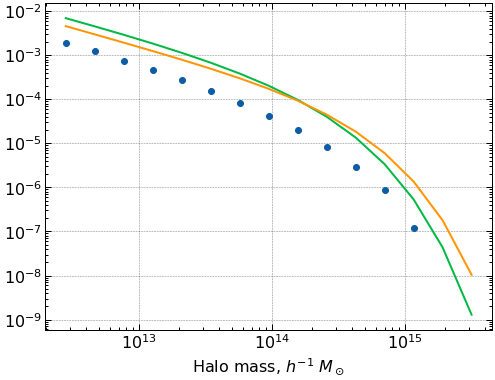

In [7]:
hmf_angulo = halos.hmfunc.MassFuncAngulo12(cosmo)
hmf_press = halos.hmfunc.MassFuncPress74(cosmo)

mass_bins = np.logspace(np.log10(32*pd.part_mass), 15.5, 15)
hmf, errors = hc.calc_fof_hmf(mass_bins)

plt.plot(mass_bins, hmf, 'o')
plt.plot(mass_bins, hmf_press.get_mass_function(cosmo, mass_bins, 1))
plt.plot(mass_bins, hmf_angulo.get_mass_function(cosmo, mass_bins, 1))
plt.loglog()
plt.xlabel("Halo mass, $h^{-1}$ $M_\\odot$")
plt.show()

### Plot correlation functions

In [6]:
r_bins = np.logspace(-1, np.log10(75), 15)
print(r_bins)
results_fof = autocorr(hc.box_size, 4, r_bins, hc.pos[:,0], hc.pos[:,1], hc.pos[:,2], output_ravg=True, verbose=True)
results_sh = autocorr(hc.box_size, 4, r_bins, hc.pos_sh[:,0], hc.pos_sh[:,1], hc.pos_sh[:,2], output_ravg=True, verbose=True)
results_dm = autocorr(pd.box_size, 4, r_bins, pd.pos[::20,0], pd.pos[::20,1], pd.pos[::20,2], output_ravg=True, verbose=True)

[ 0.1         0.16045805  0.25746787  0.41312793  0.66289703  1.06367167
  1.70674686  2.73861279  4.39432476  7.05104797 11.31397431 18.15418292
 29.12984849 46.7411878  75.        ]


In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 6,6,3.  Time taken =   0.001 sec
countpairs_xi_float> gridlink seems inefficient. nmesh = (6, 6, 3); avg_np = 308. Boosting bin refine factor - should lead to better performance
xmin = 0.000000 xmax=256.000000 rmax = 75.000000
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 10,10,3.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken =  0.148 secs
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 6,6,3.  Time taken =   0.001 sec
countpairs_xi_float> gridlink seems inefficient. nmesh = (6, 6, 3); avg_np = 345. Boosting bin refine factor - should lead to better performance
xmin = 0.000000 xmax=256.000000 rmax = 75.000000
In gridlink_float> Running with [nmesh_x, nmesh_y, nmesh_z]  = 10,10,3.  Time taken =   0.001 sec
0%.........10%.........20%.........30%.........40%.........50%.......

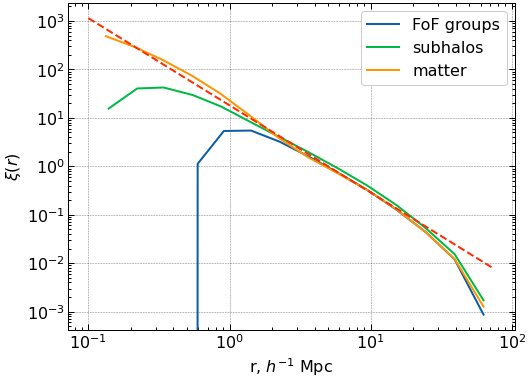

In [7]:
plt.plot(results_fof["ravg"], results_fof["xi"], label="FoF groups")
plt.plot(results_sh["ravg"], results_sh["xi"], label="subhalos")
plt.plot(results_dm["ravg"], results_dm["xi"], label="matter")
plt.plot(r_bins, (r_bins/5)**-1.8, '--')
plt.loglog()
plt.xlabel("r, $h^{-1}$ Mpc")
plt.ylabel("$\\xi(r)$")
plt.legend()
plt.show()

### Power spectrum

In [2]:
ps_file = open("/home/aaronjo2/caps/astr510_sims/run3/powerspecs/powerspec_002.txt")
lines = ps_file.readlines()
ps_file.close()

a = float(lines[0])
nbins1 = int(lines[1])
box_size = float(lines[2])
data1 = np.loadtxt(lines[5:5+nbins1])

nbins2 = int(lines[6+nbins1])
data2 = np.loadtxt(lines[10+nbins1:10+nbins1+nbins2])

nbins3 = int(lines[11+nbins1+nbins2])
data3 = np.loadtxt(lines[15+nbins1+nbins2:15+nbins1+nbins2+nbins3])

data = np.vstack((data1, data2, data3))
print(nbins1, nbins2, nbins3)

1398 1398 1200


Need to re-bin and average measurements

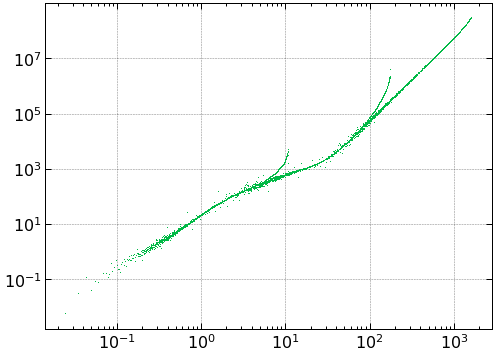

In [10]:
plt.plot(data[:,0], data[:,1], ',')
plt.plot(data[:,0], data[:,2] * data[:,0]**3 * 256**3 / (2*np.pi**2), ',')
plt.loglog()
plt.show()

134217727.0 134217727.0 70274214.0
[2.45437000e-02 3.89584472e-02 6.18391118e-02 9.81578073e-02
 1.55806816e-01 2.47313633e-01 3.92563270e-01 6.23119392e-01
 9.89083306e-01 1.56998129e+00 2.49204615e+00 3.95564844e+00
 6.27883819e+00 9.96645926e+00 1.58198551e+01 2.51110056e+01
 3.98589368e+01 6.32684675e+01 1.00426637e+02 1.59408151e+02
 2.53030066e+02 4.01637018e+02 6.37522238e+02 1.01194508e+03
 1.60627000e+03]
[       0       18       62      170      794     3292    12734    51190
   205604   824302  3271456 13153892 52767770 63591628   608679   824296
  3271462 13153892 52767773 63591607   608617   824132  3270662 13150600
 52175736]


/tmp/ipykernel_41062/848830483.py:20: RuntimeWarning: invalid value encountered in true_divide
  rebinned_data /= rebinned_n


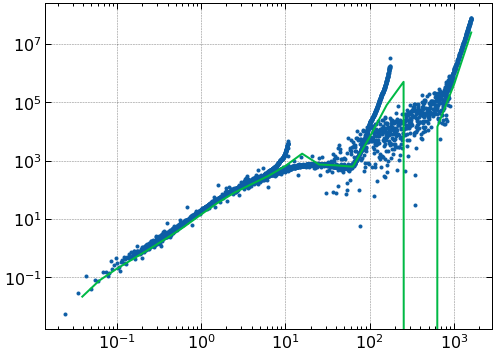

[]

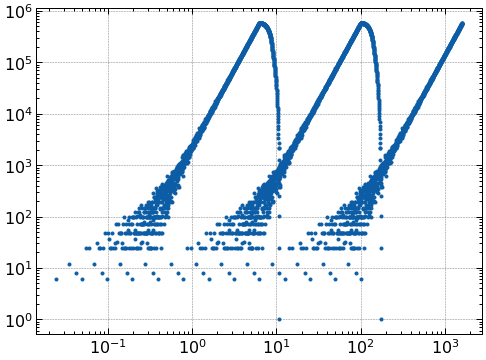

In [17]:
k_data = data[:,0]
delta_data = data[:,1] - data[:,4]
n_modes_data = data[:,3]
shot_data = data[:,4]

print(np.sum(n_modes_data[:nbins1]), np.sum(n_modes_data[nbins1:nbins1+nbins2]), np.sum(n_modes_data[nbins1+nbins2:nbins1+nbins2+nbins3]))

plt.plot(k_data, delta_data, '.')
plt.loglog()

k_bins = np.logspace(np.log10(np.min(k_data)), np.log10(np.max(k_data)), 25)
rebinned_data = np.zeros_like(k_bins)
rebinned_n = np.zeros_like(k_bins, dtype=int)
print(k_bins)
bins = np.digitize(data[:,0], k_bins)
for i, bin_i in enumerate(bins):
    if bin_i < len(k_bins):
        rebinned_data[bin_i] += delta_data[i] * data[i,3]
        rebinned_n[bin_i] += data[i,3]
rebinned_data /= rebinned_n
print(rebinned_n)
plt.plot(k_bins, rebinned_data)
#plt.plot(k_data, shot_data)
plt.show()

plt.plot(data[:,0], data[:,3], '.')
plt.loglog()

[]

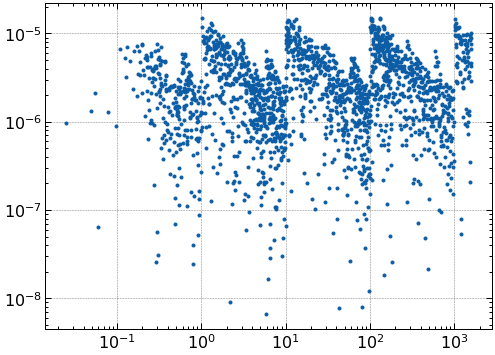

In [21]:
plt.plot(k_data, (k_data**3 / (2*np.pi**2) - shot_data) / shot_data, '.')
plt.loglog()

#### CCL predictions

(array([36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),)


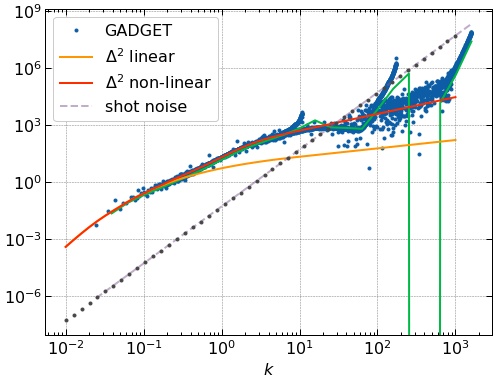

In [46]:
k = np.logspace(-2, 3, 50)
linear_power_start = cosmo.linear_power(k, a_start)
linear_power = cosmo.linear_power(k, a)
nonlin_power = cosmo.nonlin_power(k, a)

print(np.where(nonlin_power < 0.5))

delta_lin = k**3 / (2*np.pi**2) * linear_power
delta_nonlin = k**3 / (2*np.pi**2) * nonlin_power

#plt.plot(k, linear_power_start)
plt.plot(k_data, delta_data, '.', label="GADGET")
plt.plot(k_bins, rebinned_data)
plt.plot(k, delta_lin, label="$\\Delta^2$ linear")
plt.plot(k, delta_nonlin, label="$\\Delta^2$ non-linear")
plt.plot(k_data, shot_data, '--', alpha=0.5, label="shot noise")
plt.plot(k, k**3 / (2*np.pi**2), '.')
plt.loglog()
plt.xlabel("$k$")
plt.legend()
plt.show()

### Run 4

In [2]:
pd1 = snapshot.load("/home/aaronjo2/caps/astr510_sims/run4/snapshot_001.hdf5")
pd2 = snapshot.load("/home/aaronjo2/caps/astr510_sims/run4/snapshot_002.hdf5", make_tree=True)
hc = snapshot.load("/home/aaronjo2/caps/astr510_sims/run4/fof_subhalo_tab_002.hdf5", load_subhalos=True)

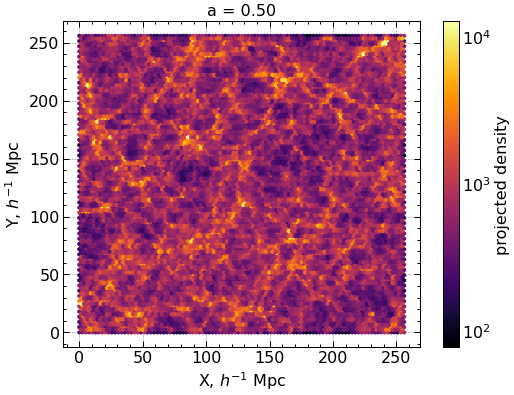

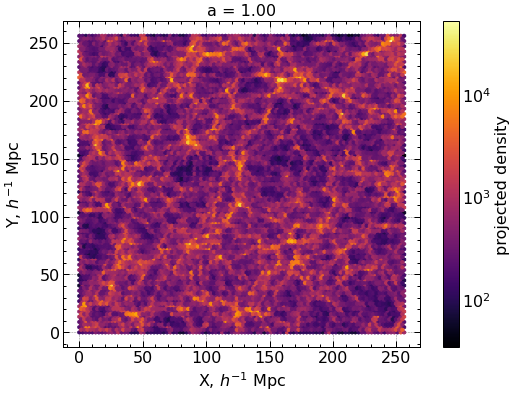

In [15]:
slice1 = np.abs(pd1.pos[:,2]) < 20
plt.hexbin(pd1.pos[slice1,0], pd1.pos[slice1,1], norm=colors.LogNorm(), cmap="inferno")
plt.title(f"a = {pd1.a:.2f}")
plt.colorbar(label="projected density")
plt.xlabel("X, $h^{-1}$ Mpc")
plt.ylabel("Y, $h^{-1}$ Mpc")
plt.show()

slice2 = np.abs(pd2.pos[:,2]) < 20
plt.hexbin(pd2.pos[slice2,0], pd2.pos[slice2,1], norm=colors.LogNorm(), cmap="inferno")
plt.title(f"a = {pd2.a:.2f}")
plt.colorbar(label="projected density")
plt.xlabel("X, $h^{-1}$ Mpc")
plt.ylabel("Y, $h^{-1}$ Mpc")
plt.show()

In [18]:
ps_file = open("/home/aaronjo2/caps/astr510_sims/run4/powerspecs/powerspec_002.txt")
lines = ps_file.readlines()
ps_file.close()

a = float(lines[0])
nbins1 = int(lines[1])
box_size = float(lines[2])
data1 = np.loadtxt(lines[5:5+nbins1])

nbins2 = int(lines[6+nbins1])
data2 = np.loadtxt(lines[10+nbins1:10+nbins1+nbins2])

nbins3 = int(lines[11+nbins1+nbins2])
data3 = np.loadtxt(lines[15+nbins1+nbins2:15+nbins1+nbins2+nbins3])

data = np.vstack((data1, data2, data3))
print(nbins1, nbins2, nbins3)

1398 1398 1200


In [19]:
k_data = data[:,0]
delta_data = data[:,1] - data[:,4]
n_modes_data = data[:,3]
shot_data = data[:,4]

(array([32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
       49]),)


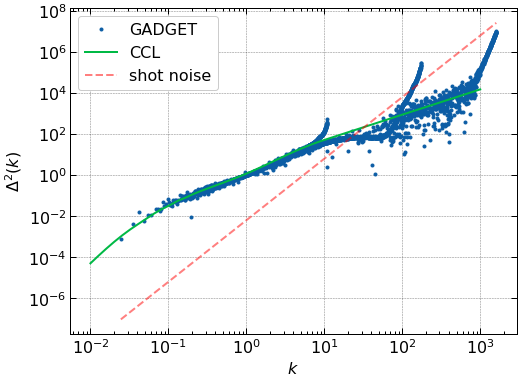

In [24]:
k = np.logspace(-2, 3, 50)
linear_power_start = cosmo.linear_power(k, a_start)
linear_power = cosmo.linear_power(k, a)
nonlin_power = cosmo.nonlin_power(k, a)

print(np.where(nonlin_power < 0.5))

delta_lin = k**3 / (2*np.pi**2) * linear_power
delta_nonlin = k**3 / (2*np.pi**2) * nonlin_power

#plt.plot(k, linear_power_start)
plt.plot(k_data, delta_data, '.', label="GADGET")
#plt.plot(k_bins, rebinned_data)
#plt.plot(k, delta_lin, label="$\\Delta^2$ linear")
plt.plot(k, delta_nonlin, label="CCL")
plt.plot(k_data, shot_data, 'r--', alpha=0.5, label="shot noise")
#plt.plot(k, k**3 / (2*np.pi**2), '.')
plt.loglog()
plt.xlabel("$k$")
plt.ylabel("$\\Delta^2(k)$")
plt.legend()
plt.show()

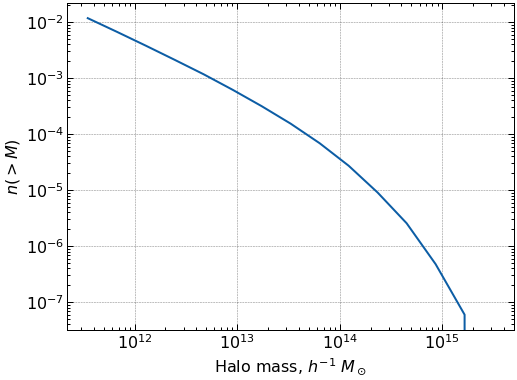

In [26]:
mass_bins = np.logspace(np.log10(32*pd.part_mass), 15.5, 15)
hmf, errors = hc.calc_fof_hmf(mass_bins)
plt.plot(mass_bins, hmf)
plt.loglog()
plt.xlabel("Halo mass, $h^{-1}$ $M_\\odot$")
plt.ylabel("$n(>M)$")
plt.show()

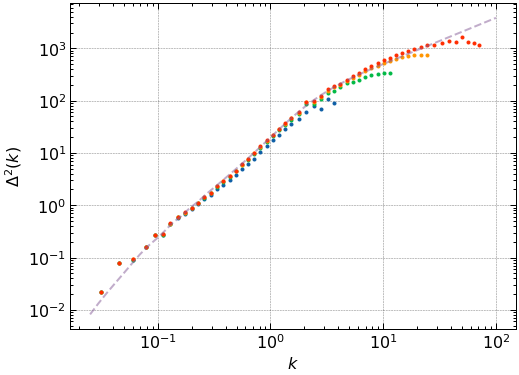

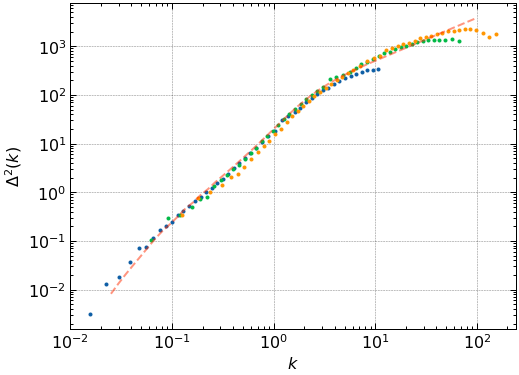

In [6]:
k = np.logspace(-1.6, 2, 50)
nonlin_power = cosmo.nonlin_power(k, 1)

delta_nonlin = k**3 / (2*np.pi**2) * nonlin_power

for i in range(1,5):
    ps_file = f"summary_data/run{i}/powespec_002.npz"
    data = np.load(ps_file)
    plt.plot(data["k"], data["delta"], '.')

plt.plot(k, delta_nonlin, '--', alpha=0.5)
plt.loglog()
plt.xlabel("$k$")
plt.ylabel("$\\Delta^2(k)$")
plt.show()

for i in range(13,16):
    ps_file = f"summary_data/run{i}/powespec_002.npz"
    data = np.load(ps_file)
    plt.plot(data["k"], data["delta"], '.')

plt.plot(k, delta_nonlin, '--', alpha=0.5)
plt.loglog()
plt.xlabel("$k$")
plt.ylabel("$\\Delta^2(k)$")
plt.show()

## Halo density profiles

#### NFW profile
Scale radius $R_s$ and scale density $\rho_0$:
$$\rho = \frac{\rho_0}{r/R_s(1+r/R_s)^2}$$

In [80]:
def nfw(params, r):
    rho_0, r_s = params
    return rho_0 / (r/r_s * (1 + r/r_s)**2)

def nfw_gradient(params, r):
    rho_0, r_s = params
    rho = nfw(params, r)
    return np.array([rho/rho_0, -rho/r_s * (1/(r/r_s) + 2/(1+r/r_s))])

nfw_model = odr.Model(nfw, fjacb=nfw_gradient)

In [4]:
i = 0
inds = hc.get_particles(i)

center = hc.pos[i]
pos = utils.center_box_pbc(pd2.pos[inds], center, pd2.box_size)
radius = np.max(np.linalg.norm(pos, axis=1))

print(f"{len(inds)} particles")
print(center, radius)
pos = utils.center_box_pbc(pd2.pos[pd2.query_radius(center, radius)], center, pd2.box_size)

165131 particles
[ 71.04219   72.500084 242.41605 ] 7.10999561569494


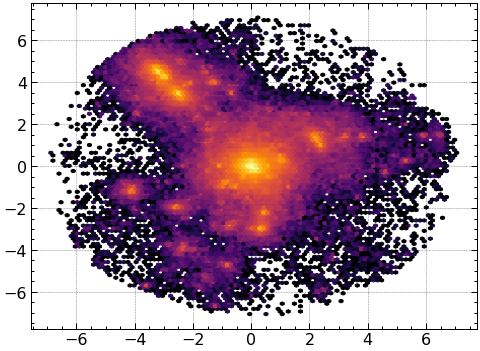

In [5]:
plt.hexbin(pos[:,0], pos[:,1], norm=colors.LogNorm(), cmap="inferno", mincnt=1)
plt.show()

In [39]:
def get_sphere_samples(r, n):
    golden_ratio = (1 + 5**0.5)/2
    i = np.arange(n)
    theta = 2 * np.pi * i / golden_ratio
    phi = np.arccos(1 - 2*(i + 0.5)/n)
    return np.vstack((r*np.cos(theta)*np.sin(phi), r*np.sin(theta)*np.sin(phi), r*np.cos(phi))).T

In [61]:
%%timeit
get_sphere_samples(5, 2500)

317 µs ± 4.62 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [79]:
kde = gaussian_kde(pos.T, bw_method=0.008)
r = np.logspace(-2, np.log10(radius), 15)
areas = 4*np.pi*r**2
coeff = 5/np.median(areas)
samples = np.round(np.clip(coeff*areas, 3, 500)).astype(int)
print(samples)
print(np.sum(samples))
prob_dens = np.zeros_like(r)
error = np.zeros_like(r)
for i, r_val in enumerate(r):
    #pos_eval = np.random.randn(samples[i], 3)
    #pos_eval = r_val * pos_eval / np.expand_dims(np.linalg.norm(pos_eval, axis=1), 1)
    pos_eval = get_sphere_samples(r_val, samples[i])
    dens = kde.evaluate(pos_eval.T)
    prob_dens[i] = np.mean(dens)
    error[i] = np.std(dens)

[  3   3   3   3   3   3   3   5  13  33  83 213 500 500 500]
1868


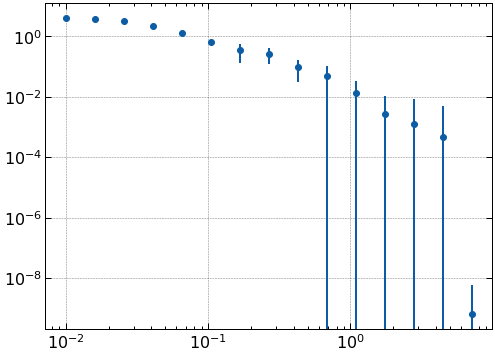

In [76]:
plt.errorbar(r, prob_dens, yerr=error, fmt='o')
plt.loglog()
plt.show()

In [77]:
r_centered = 0.5*(r[1:] + r[:-1])
avg_dens = np.cumsum(4*np.pi * r_centered**2 * (r[1:] - r[:-1]) * 0.5*(prob_dens[1:] + prob_dens[:-1])) / (4/3 * np.pi * r_centered**3)
r_vir = r_centered[np.argmin(np.abs(avg_dens * pd2.query_radius(center, radius, count_only=True) - 358*pd2.mean_matter_density/pd2.part_mass))]
print("Virial radius", r_vir)

Virial radius 2.2617389221850446


Beta: [0.18611211 0.62897253]
Beta Std Error: [0.05649056 0.09407844]
Beta Covariance: [[ 4.24537332 -6.99002421]
 [-6.99002421 11.77455177]]
Residual Variance: 0.0007516849667085123
Inverse Condition #: 0.05958286618060139
Reason(s) for Halting:
  Sum of squares convergence


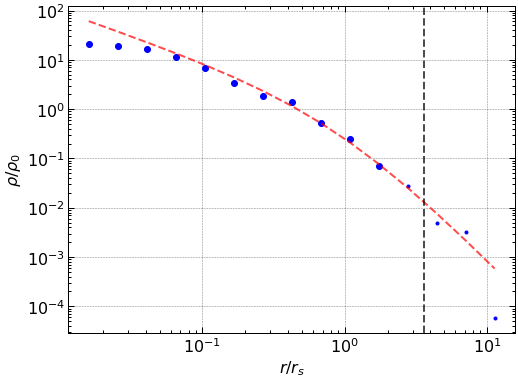

In [81]:
mask = r < r_vir / 2
data = odr.RealData(r[mask], prob_dens[mask], sy=error[mask])
odr_fit = odr.ODR(data, nfw_model, beta0=[0.5, 0.5])
odr_output = odr_fit.run()
odr_output.pprint()

plt.plot(r[mask] / odr_output.beta[1], prob_dens[mask] / odr_output.beta[0], 'bo')
plt.plot(r[~mask] / odr_output.beta[1], prob_dens[~mask] / odr_output.beta[0], 'b.')
plt.plot(r / odr_output.beta[1], nfw(odr_output.beta, r) / odr_output.beta[0], 'r--', alpha=0.7)
plt.axvline(r_vir / odr_output.beta[1], ls='--', color='black', alpha=0.7)
plt.loglog()
plt.xlabel("$r/r_s$")
plt.ylabel("$\\rho/\\rho_0$")
plt.show()

### Compare profiles of most massive halos


halo 0: 165131 particles, radius: 7.110
Virial radius 2.2617389221850446
Beta: [0.19445923 0.62167579]
Beta Std Error: [0.03542816 0.05603584]
Beta Covariance: [[ 4.94072708 -7.72605764]
 [-7.72605764 12.36019603]]
Residual Variance: 0.00025404251667225295
Inverse Condition #: 0.06160920118269759
Reason(s) for Halting:
  Sum of squares convergence

halo 1: 118207 particles, radius: 3.485
Virial radius 2.889394205024339
Beta: [0.15888214 1.06827232]
Beta Std Error: [0.01799802 0.07357584]
Beta Covariance: [[  4.60356359 -18.60874818]
 [-18.60874818  76.93339557]]
Residual Variance: 7.036481307039333e-05
Inverse Condition #: 0.03022273701074291
Reason(s) for Halting:
  Sum of squares convergence

halo 2: 109154 particles, radius: 4.704
Virial radius 2.4920350975034067
Beta: [1.04791507 0.36132809]
Beta Std Error: [0.12383414 0.01980824]
Beta Covariance: [[308.95759079 -48.95732611]
 [-48.95732611   7.9051427 ]]
Residual Variance: 4.9634299783243435e-05
Inverse Condition #: 0.01920196792

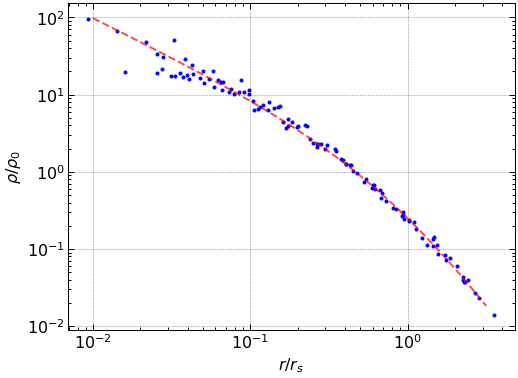

In [222]:
for i in range(10):
    inds = hc.get_particles(i)
    center = hc.pos[i]
    pos = utils.center_box_pbc(pd2.pos[inds], center, pd2.box_size)
    radius = np.max(np.linalg.norm(pos, axis=1))

    print(f"\nhalo {i}: {len(inds)} particles, radius: {radius:.3f}")
    pos = utils.center_box_pbc(pd2.pos[pd2.query_radius(center, radius)], center, pd2.box_size)
    
    kde = gaussian_kde(pos.T, bw_method=0.008)
    r = np.logspace(-2, np.log10(radius), 15)
    prob_dens = np.zeros_like(r)
    error = np.zeros_like(r)
    for i, r_val in enumerate(r):
        area = 4*np.pi*r_val**2
        pos_eval = np.random.randn(min(max(int(5e2*area), 5), 500), 3)
        print(len(pos_eval))
        pos_eval = r_val * pos_eval / np.expand_dims(np.linalg.norm(pos_eval, axis=1), 1)
        dens = kde.evaluate(pos_eval.T)
        prob_dens[i] = np.mean(dens)
        error[i] = np.std(dens)
    
    r_centered = 0.5*(r[1:] + r[:-1])
    avg_dens = np.cumsum(4*np.pi * r_centered**2 * (r[1:] - r[:-1]) * 0.5*(prob_dens[1:] + prob_dens[:-1])) / (4/3 * np.pi * r_centered**3)
    r_vir = r_centered[np.argmin(np.abs(avg_dens * pd2.query_radius(center, radius, count_only=True) - 358*pd2.mean_matter_density/pd2.part_mass))]
    print("Virial radius", r_vir)

    mask = r < r_vir / 2
    data = odr.RealData(r[mask], prob_dens[mask], sy=error[mask])
    odr_fit = odr.ODR(data, nfw_model, beta0=[1, 0.5])
    odr_output = odr_fit.run()
    odr_output.pprint()

    plt.plot(r[mask] / odr_output.beta[1], prob_dens[mask] / odr_output.beta[0], 'b.')
    #plt.plot(r[~mask] / odr_output.beta[1], prob_dens[~mask] / odr_output.beta[0], 'b.')
    
r = np.logspace(-2, 0.5, 50)
plt.plot(r, nfw([1,1], r), 'r--', alpha=0.7)
plt.loglog()
plt.xlabel("$r/r_s$")
plt.ylabel("$\\rho/\\rho_0$")
plt.show()

In [238]:
r = np.logspace(-2, 1, 20)
print(r)
area = 4*np.pi*r**2
coeff = 50 / np.median(area)
print(coeff)
print(np.round(np.clip(coeff * area, 3, 500)))
print(np.round(np.clip(5e2 * area, 5, 500)))
#min(max(int(5e2*area), 5), 500)

[ 0.01        0.0143845   0.02069138  0.02976351  0.04281332  0.06158482
  0.08858668  0.1274275   0.18329807  0.26366509  0.37926902  0.54555948
  0.78475997  1.12883789  1.62377674  2.33572147  3.35981829  4.83293024
  6.95192796 10.        ]
37.296531478930824
[  3.   3.   3.   3.   3.   3.   4.   8.  16.  33.  67. 139. 289. 500.
 500. 500. 500. 500. 500. 500.]
[  5.   5.   5.   6.  12.  24.  49. 102. 211. 437. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500.]


165131 particles
radius 7.10999561569494

4.277e+04
4.245e+04

118207 particles
radius 3.4847917848078076

4.868e+04
4.629e+04

Beta: [4.62884450e+04 6.47855252e-01]
Beta Std Error: [1.16267457e+04 8.61394166e-02]
Beta Covariance: [[ 7.74688824e+10 -5.69129457e+05]
 [-5.69129457e+05  4.25221090e+00]]
Residual Variance: 0.0017449743810854378
Inverse Condition #: 0.05715528899936253
Reason(s) for Halting:
  Iteration limit reached



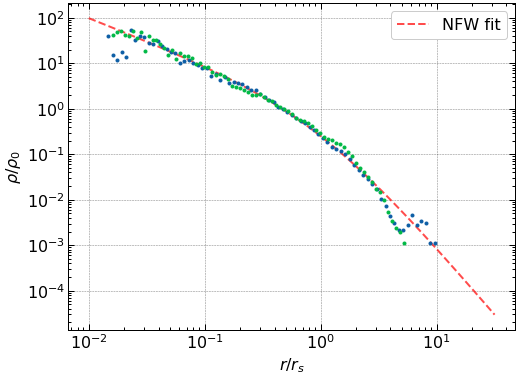

In [27]:
for i in range(2):
    center = hc.pos[i]
    inds = hc.get_particles(i)
    print(len(inds), "particles")
    pos = utils.center_box_pbc(pd2.pos[inds], center, pd2.box_size)
    radius = np.max(np.linalg.norm(pos, axis=1))
    print("radius", radius)
    inds = pd2.query_radius(center, radius)
    pos = utils.center_box_pbc(pd2.pos[inds], center, pd2.box_size)
    r = np.linalg.norm(pos, axis=1)
    rbins = np.logspace(-2, np.log10(np.max(r)+1e-2), 75)
    dr = rbins[1:] - rbins[:-1]
    rbin_centers = 0.5 * (rbins[1:] + rbins[:-1])
    bin_inds = np.digitize(r, rbins)
    mass = np.bincount(bin_inds)[1:] * pd2.part_mass
    density = mass / (4/3*np.pi * (rbins[1:]**3 - rbins[:-1]**3))
    errors = np.sqrt(mass) / (4/3*np.pi * (rbins[1:]**3 - rbins[:-1]**3))
    density_avg = np.cumsum(density * 4/3*np.pi * (rbins[1:]**3 - rbins[:-1]**3)) / (4/3 * np.pi * rbins[1:]**3)
    i_vir = np.argmin(np.abs(density_avg - 358*pd2.mean_matter_density))
    r_vir = rbin_centers[i_vir]
    
    mask = rbin_centers < r_vir / 2
    data = odr.Data(rbin_centers[mask], density[mask]/1e10)
    
    odr_fit = odr.ODR(data, nfw_model, beta0=[0.25 * (density[0] + density[i_vir]) / 1e11, 0.5])
    odr_output = odr_fit.run()
    
    print()
    print(f"{0.25 * (density[0] + density[i_vir]) / 1e11:.3e}")
    print(f"{odr_output.beta[0]:.3e}")
    print()
    
    if "Iteration limit reached" in odr_output.stopreason:
        odr_output.pprint()
        print()
    
    r_scaled = rbin_centers / odr_output.beta[1]
    density_scaled = density / 1e10 / odr_output.beta[0]
    errors_scaled = errors / 1e10 / odr_output.beta[0]
    #plt.plot(r_scaled, density_scaled, '.')
    plt.errorbar(r_scaled, density_scaled, yerr=errors_scaled, fmt='.')

x = np.logspace(-2, 1.5, 100)
plt.plot(x, nfw([1,1], x), '--', color='red', alpha=0.7, label="NFW fit")
plt.loglog()
plt.xlabel("$r/r_s$")
plt.ylabel("$\\rho/\\rho_0$")
plt.legend()
plt.show()

In [10]:
10**-2.3

0.005011872336272725

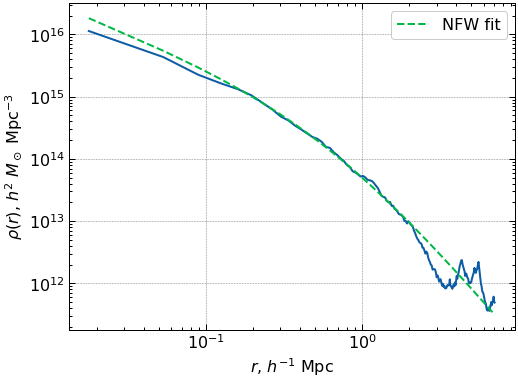

In [119]:
plt.plot(rbins_centers, density)
plt.plot(rbins_centers, nfw(odr_output.beta, rbins_centers), '--', label="NFW fit")
plt.loglog()
plt.xlabel("$r$, $h^{-1}$ Mpc")
plt.ylabel("$\\rho(r)$, $h^2$ $M_\odot$ Mpc$^{-3}$")
plt.legend()
plt.show()

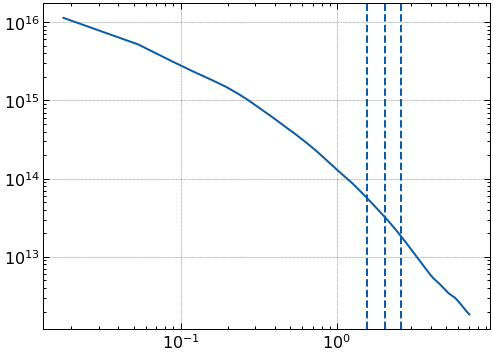

In [120]:
density_avg = np.cumsum(density * 4/3*np.pi * (rbins[1:]**3 - rbins[:-1]**3)) / (4/3 * np.pi * rbins[1:]**3)
i_200m = np.argmin(np.abs(density_avg - 200*pd2.mean_matter_density))
i_200c = np.argmin(np.abs(density_avg - 200*pd2.flat_crit_density))
i_358m = np.argmin(np.abs(density_avg - 358*pd2.mean_matter_density))

plt.plot(rbins_centers, density_avg)
plt.loglog()
plt.axvline(rbins[i_358m], ls='--')
plt.axvline(rbins[i_200m], ls='--')
plt.axvline(rbins[i_200c], ls='--')
#plt.axhline(200*pd2.mean_matter_density, ls='--')

In [82]:
f"{np.sum(density * 4*np.pi * rbins_centers**2 * (rbins_centers[1] - rbins_centers[0])):.3e}", f"{np.sum(mass):.3e}"

('2.741e+15', '2.743e+15')

In [133]:
def radial_profile(pos, part_mass, rho_matter, rho_crit, bins=100):
    r = np.linalg.norm(pos, axis=1)
    rbins = np.linspace(0, np.max(r)+1e-3, bins)
    dr = rbins[1] - rbins[0]
    rbin_centers = 0.5 * (rbins[1:] + rbins[:-1])
    
    bin_inds = np.digitize(r, rbins)
    mass = np.bincount(bin_inds)[1:] * part_mass
    density = mass / (4/3 * np.pi * (rbins[1:]**3 - rbins[:-1]**3))
    density_avg = np.cumsum(density * 4/3*np.pi * (rbins[1:]**3 - rbins[:-1]**3)) / (4/3 * np.pi * rbins[1:]**3)
    
    r_200m = rbin_centers[np.argmin(np.abs(density_avg - 200*rho_matter))]
    r_200c = rbin_centers[np.argmin(np.abs(density_avg - 200*rho_crit))]
    r_vir = rbin_centers[np.argmin(np.abs(density_avg - 358*rho_matter))]
    
    return rbin_centers, density, r_200m, r_200c, r_vir

1.036483299213907
Beta: [2.89909216e+03 2.55775182e-01]
Beta Std Error: [3.23937839e+02 1.15975147e-02]
Beta Covariance: [[ 3.24595624e+08 -1.15931556e+04]
 [-1.15931556e+04  4.16053480e-01]]
Residual Variance: 0.0003232813875085032
Inverse Condition #: 0.029741803103199835
Reason(s) for Halting:
  Sum of squares convergence


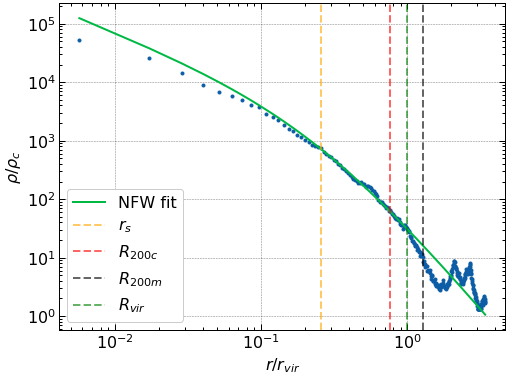

Concentration parameter: 3.910


In [170]:
r, dens, r200m, r200c, rvir = radial_profile(pos - center, pd2.part_mass, pd2.mean_matter_density, pd2.flat_crit_density, bins=300)
r /= rvir
dens /= pd2.flat_crit_density

mask = r < 0.5 * rvir
print(0.5*rvir)
data = odr.Data(r[mask], dens[mask])
odr_fit = odr.ODR(data, nfw_model, beta0=[1e4, 0.5])
odr_output = odr_fit.run()
odr_output.pprint()

plt.plot(r, dens, '.')
plt.plot(r, nfw(odr_output.beta, r), '-', label="NFW fit")
plt.axvline(odr_output.beta[1], ls='--', color='orange', alpha=0.6, label="$r_s$")
plt.axvline(r200c/rvir, ls='--', color='red', alpha=0.6, label="$R_{200c}$")
plt.axvline(r200m/rvir, ls='--', color='black', alpha=0.6, label="$R_{200m}$")
plt.axvline(1, ls='--', color='green', alpha=0.6, label="$R_{vir}$")
plt.loglog()
plt.legend()
plt.xlabel("$r/r_{vir}$")
plt.ylabel("$\\rho/\\rho_{c}$")
plt.show()

print(f"Concentration parameter: {1/odr_output.beta[1]:.3f}")

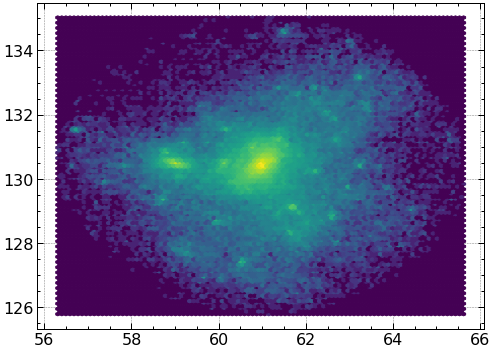

0.9481246294512797
Beta: [5.51171743e+03 1.89523415e-01]
Beta Std Error: [1.54386832e+03 2.07078474e-02]
Beta Covariance: [[ 1.31476554e+09 -1.75987821e+04]
 [-1.75987821e+04  2.36536253e-01]]
Residual Variance: 0.001812893107988223
Inverse Condition #: 0.013717184538355739
Reason(s) for Halting:
  Iteration limit reached


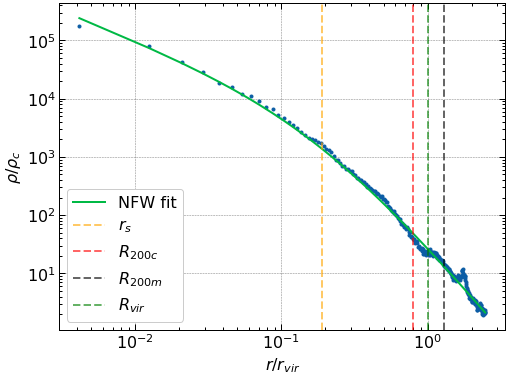

Concentration parameter: 5.276


In [165]:
inds = hc.get_particles(2)
center = hc.pos[2]
pos = utils.center_box_pbc(pd2.pos[inds], center, pd2.box_size)
radius = np.max(np.linalg.norm(pos, axis=1))

pos = pd2.pos[pd2.query_radius(center, radius)]
plt.hexbin(pos[:,0], pos[:,1], norm=colors.LogNorm())
plt.show()

r, dens, r200m, r200c, rvir = radial_profile(pos - center, pd2.part_mass, pd2.mean_matter_density, pd2.flat_crit_density, bins=300)
r /= rvir
dens /= pd2.flat_crit_density

mask = r < 0.5 * rvir
print(0.5*rvir)
data = odr.Data(r[mask], dens[mask])
odr_fit = odr.ODR(data, nfw_model, beta0=[1e4, 0.5])
odr_output = odr_fit.run()
odr_output.pprint()

plt.plot(r, dens, '.')
plt.plot(r, nfw(odr_output.beta, r), '-', label="NFW fit")
plt.axvline(odr_output.beta[1], ls='--', color='orange', alpha=0.6, label="$r_s$")
plt.axvline(r200c/rvir, ls='--', color='red', alpha=0.6, label="$R_{200c}$")
plt.axvline(r200m/rvir, ls='--', color='black', alpha=0.6, label="$R_{200m}$")
plt.axvline(1, ls='--', color='green', alpha=0.6, label="$R_{vir}$")
plt.loglog()
plt.legend()
plt.xlabel("$r/r_{vir}$")
plt.ylabel("$\\rho/\\rho_{c}$")
plt.show()

print(f"Concentration parameter: {1/odr_output.beta[1]:.3f}")